<a href="https://colab.research.google.com/github/maciejskorski/Good-Turing-MSE/blob/main/Good_Turing_MSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Good-Turing Estimator for Missing Mass

The briliant method due to Good and Turing allows for estimating objects missing in a sample. The problem, known under names "sample coverage" or "missing mass" goes back to their cryptographic work during WWII, but over years has found has many applications, including language modeling, inference in ecology, estimation of entropy and distribution properties.




# Mean Squared Accuracy of GT Estimator

The mean squared error of the estimator is related to occupancy numbers, and can be approximated as a Poisson-like expression:
$$
MSE = \frac{n\sum_{s}p_s^2\mathrm{e}^{-np_s}+\sum_{s}p_s\mathrm{e}^{-np_s}-\left(\sum_{s}p_s\mathrm{e}^{-np_s}\right)^2}{n} + O(n^{-2}),
$$
where $n$ is the sample size and $(p_s)$ are the distribution weights (see the paper). 

**Since we do not know the weights, we ask for the robust (maximum) bound. 
We solve this problem for any support size $m$ of the distribution.**
In general, the maximal MSE occurs at a combination of a uniform distribution and a dirac mass (see the paper for details).

Text(0.5, 0, 'mixture weight')

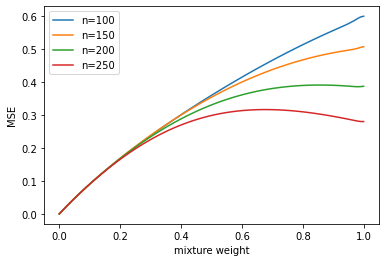

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def gt_mse(n,p):
  ''' for distribution p, outputs the constant A in the asymptotic A/#sample for mse of GT Estimator, '''
  out = n*((p**2)*np.exp(-n*p)).sum(-1) + (p*np.exp(-n*p)).sum(-1) - (p*np.exp(-n*p)).sum(-1)**2
  return out

m = 100

for n in [100,150,200,250]:

  # generate mixtures Dirichlet + Uniform

  p_uniform = np.ones(m)/m
  p_dirac = np.zeros(m)
  p_dirac[-1] = 1
  ws = np.linspace(0,1,101).reshape(-1,1)
  ps = (ws*p_uniform+(1-ws)*p_dirac)

  plt.plot(ws.ravel(),gt_mse(n,ps),label='n=%s'%n)
plt.legend()
plt.ylabel('MSE')
plt.xlabel('mixture weight')

# Worse Mean Squared Error

The precise behavior of the worst case can be determined with non-linear programming. 

The optimization can be reduced to an auxiliary 2-D optimization task.

Below we show the auxiliary and final result (see the paper for details). 

Note the phase transition depending on $m/n$!

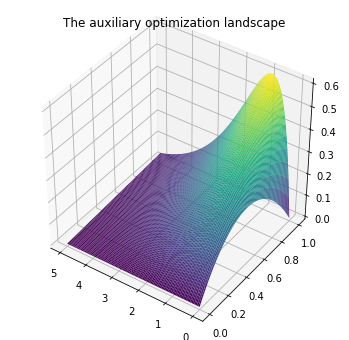

In [2]:
from mpl_toolkits import mplot3d

def f(x, y):
    return y*(x+1)*np.exp(-x) - y**2*np.exp(-2*x)

x = np.linspace(0, 5, 100)
y = np.linspace(0, 1, 100)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.view_init(-140, 55)
ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('The auxiliary optimization landscape');
ax.invert_zaxis()

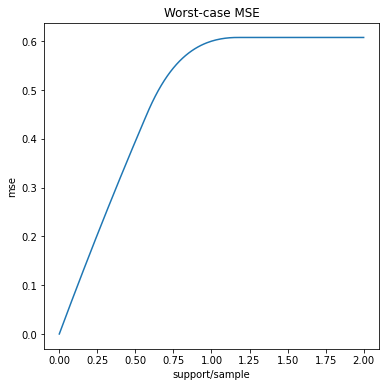

In [3]:
import numpy as np
from scipy.optimize import minimize_scalar
from matplotlib import pyplot as plt

def gt_worst_mse(b):
  ''' constant A in the asymptotic A/#sample for max mse of good-turing estimator, when #alphabet/#sample is b 
      also outputs the maximizer characterization
  '''

  if b == 0:
    return (0,0,0)
  else:

    # first case (uniform distribution)
    fun = lambda c: -( (1+c)*np.exp(-c) -np.exp(-2*c) )
    out = minimize_scalar(fun=fun,method='bounded',bounds = [1/b,1/b+2])
    out1 = np.array([1,out.x,-out.fun])
    
    # second case (mixture of uniform+Dirac)
    fun = lambda c: -( (1+c)*np.exp(-c) -np.exp(-2*c) )
    fun = lambda c: -( b*(c**2+c)*np.exp(-c) - b**2*c**2*np.exp(-2*c) )
    out= minimize_scalar(fun=fun,method='bounded',bounds = [0,1/b])
    out2 = np.array([b*out.x,out.x,-out.fun])

    out = np.vstack([out1,out2])
    return out[ out[:,-1].argmax() ]

bs = np.linspace(0.0,2,201)
mses = np.array([gt_worst_mse(b) for b in bs])
plt.figure(figsize=(6,6))
plt.xlabel('support/sample')
plt.ylabel('mse')
plt.title('Worst-case MSE')
plt.plot(bs,mses[:,-1])
plt.show()

# Numerical Examples

Consider two cases $m=100,n=50$ and $m=100,n=200$.

We will show the worse-case MSE along with the proportion $w$ for the Uniform-Dirac mixture (characterizes the worse-case distribution).

In [4]:
for (m,n) in ((100,50),(100,200)):

  b = m/n
  w,c,_=mses[bs==b].ravel()

  p_uniform = np.ones(int(w*n/c))
  p_uniform = p_uniform/len(p_uniform)
  p_dirac = np.zeros_like(p_uniform)
  p_dirac[-1] = 1
  ws = np.linspace(0,1,101).reshape(-1,1)
  p = w*p_uniform+(1-w)*p_dirac
  print('m=%.2f,n=%.2f,w=%.2f,MSE=%.2f'%(m,n,w,gt_mse(n,p)))

m=100.00,n=50.00,w=1.00,MSE=0.61
m=100.00,n=200.00,w=0.86,MSE=0.39
